# Neuroblastoma

## Imports python

In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.optim as optim
import torchmetrics.classification as classification
import copy
import matplotlib.pyplot as plt
import numpy as np
import json
import os

from torch import nn

/home/pierre/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



## Vérification GPU

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


## Chargement des datasets et preprocessing

In [3]:
root_dir  = "../database/250/leak_experience/Exp_2/"
train_dir = "train/"
valid_dir = "valid/"
test_dir  = "test/"

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.66747984797634830, 0.5799524696639141, 0.78054363559995920), (0.23162625605944703, 0.2340601507820534, 0.14160506754101998)),
    transforms.RandomCrop((224, 224))]
)
eval_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.66747984797634830, 0.5799524696639141, 0.78054363559995920), (0.23162625605944703, 0.2340601507820534, 0.14160506754101998)),
    transforms.CenterCrop((224, 224))]
)

# Chargement des données
train_dataset = datasets.ImageFolder(f"{root_dir}/{train_dir}", train_transform)
valid_dataset = datasets.ImageFolder(f"{root_dir}/{valid_dir}", eval_transform)
test_dataset  = datasets.ImageFolder(f"{root_dir}/{test_dir}",  eval_transform)

## Modèle

In [25]:
from Models.leak_test_net import LeakTestNet

## Entraînement

In [26]:
batch_size = 32
lr = 4e-6
epochs = 100

model = LeakTestNet().to(device)

optimizer = optim.Adam(model.parameters(), lr, betas=(0.9, 0.999))
criterion = nn.BCELoss()
accuracy  = classification.BinaryAccuracy().to(device)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size, shuffle=False)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size, shuffle=False)

In [27]:
def train_model(model, loader, criterion, accuracy, epoch:int=0):
    loss, accu = np.zeros((len(loader))), np.zeros((len(loader)))
    accuracy.reset()
    model.train()
    for b, (inputs, labels) in enumerate(loader):
        (inputs, labels) = (inputs.to(device), labels.to(device))
        labels  = labels.unsqueeze(1).to(torch.float32)
        outputs = model(inputs)
        cr_loss = criterion(outputs, labels)

        optimizer.zero_grad()
        cr_loss.backward()
        optimizer.step()

        loss[b] = cr_loss.item()
        accu[b] = accuracy(outputs, labels).item()
    mean_loss = np.mean(loss)
    mean_accu = np.mean(accu)
    return mean_loss, loss, mean_accu, accu


def eval_model(model, loader, criterion, accuracy, epoch:int=0):
    loss, accu = np.zeros((len(loader))), np.zeros((len(loader)))
    accuracy.reset()
    model.eval()
    with torch.no_grad():    
        for b, (inputs, labels) in enumerate(loader):
            (inputs, labels) = (inputs.to(device), labels.to(device))
            labels  = labels.unsqueeze(1).to(torch.float32)
            outputs = model(inputs)

            cr_loss = criterion(outputs, labels)
            loss[b] = cr_loss.item()
            accu[b] = accuracy(outputs, labels).item()
    mean_loss = np.mean(loss)
    mean_accu = np.mean(accu)
    return mean_loss, loss, mean_accu, accu

def print_H_at_epoch(H, e:int=0):
    print(f"Epoch {e:3d}: Train=({H['train']['m_loss'][e]:.3f}, {H['train']['m_accu'][e]:.2%})", end=" | ")
    print(              f"Valid=({H['valid']['m_loss'][e]:.3f}, {H['valid']['m_accu'][e]:.2%})")
    
# Historic
H = {
    "train": {"loss":   np.zeros((epochs+1, len(train_loader))),
              "accu":   np.zeros((epochs+1, len(train_loader))),
              "m_loss": np.zeros((epochs+1)),
              "m_accu": np.zeros((epochs+1))},
    "valid": {"loss":   np.zeros((epochs+1, len(valid_loader))),
              "accu":   np.zeros((epochs+1, len(valid_loader))),
              "m_loss": np.zeros((epochs+1)),
              "m_accu": np.zeros((epochs+1))}
}

(H["train"]["m_loss"][0], H["train"]["loss"][0, :],
 H["train"]["m_accu"][0], H["train"]["accu"][0, :]) = eval_model(model, train_loader, criterion, accuracy, epoch=0)
(H["valid"]["m_loss"][0], H["valid"]["loss"][0, :],
 H["valid"]["m_accu"][0], H["valid"]["accu"][0, :]) = eval_model(model, valid_loader, criterion, accuracy, epoch=0)

print_H_at_epoch(H, 0)
best_valid_accu = H["valid"]["m_accu"][0]
best_model = copy.deepcopy(model)

for e in range(1, epochs+1):
    (H["train"]["m_loss"][e], H["train"]["loss"][e, :],
     H["train"]["m_accu"][e], H["train"]["accu"][e, :]) = train_model(model, train_loader, criterion, accuracy, e)
    
    (H["valid"]["m_loss"][e], H["valid"]["loss"][e, :],
     H["valid"]["m_accu"][e], H["valid"]["accu"][e, :]) = eval_model(model, valid_loader, criterion, accuracy, e)

    print_H_at_epoch(H, e)
    if H["valid"]["m_accu"][e] > best_valid_accu:
        best_valid_accu = H["valid"]["m_accu"][e]
        best_model = copy.deepcopy(model)

(mean_loss, loss, mean_accu, accu) = eval_model(best_model, test_loader, criterion, accuracy)
print(f"Best model: ({mean_loss:.3f}, {mean_accu:.2%})")

Epoch   0: Train=(0.693, 46.46%) | Valid=(0.698, 44.76%)


KeyboardInterrupt: 

## Visualisation des courbes d'apprentissage

In [19]:
def plot_metric(H, max_epoch:int, metric:str="accu"):
    fig = plt.figure(figsize=(6, 3))

    cmap = plt.get_cmap("tab10")
    colors = [cmap(1), cmap(0)]
    xline = np.arange(max_epoch+1)
    handles = []
    labels = ["valid", "train"]

    for c, dataset in zip(colors, labels):
        std  = np.sqrt(np.var(H[dataset][metric], axis=1))[:max_epoch+1]
        mean = H[dataset][f"m_{metric}"][:max_epoch+1]
        plt.fill_between(xline, mean-std, mean+std, linewidth=0, color=c, alpha=0.4)
        line, = plt.plot(xline, mean, color=c)
        handles += [line]

    plt.xlabel("epoch")
    if metric == "accu":
        plt.ylim([min(min(H["train"]["m_accu"]), min(H["valid"]["m_accu"])), 1])
    elif metric == "loss":
        plt.ylim([0, max(max(H["train"][f"m_loss"]), max(H["valid"][f"m_loss"]))])
    plt.legend(handles[::-1], labels[::-1])
    plt.grid()

In [ ]:
os.makedirs("backup", exist_ok=True)
backup_folder = "backup/new"
os.makedirs(backup_folder, exist_ok=True)    
    
plot_metric(H, max_epoch=epochs, metric="accu")
plt.savefig(f"{backup_folder}/accu.pdf", bbox_inches="tight")
plot_metric(H, max_epoch=epochs, metric="loss")
plt.savefig(f"{backup_folder}/loss.pdf", bbox_inches="tight")

## Sauvegarde

In [ ]:
torch.save(model.state_dict(), f"{backup_folder}/model.pth")

backup = {}
backup["loader"] = {"train": len(train_loader), "valid": len(valid_loader), "test": len(test_loader)}
backup["opti"]   = {"optimizer": "Adam", "lr": lr, "batch_size": batch_size, "epochs": epochs}
backup["train_loss"] = H["train"]["m_loss"].tolist()
backup["train_accu"] = H["train"]["m_accu"].tolist()
backup["valid_loss"] = H["valid"]["m_loss"].tolist()
backup["valid_accu"] = H["valid"]["m_accu"].tolist()
backup["train_loss_batch"] = H["train"]["loss"].tolist()
backup["train_accu_batch"] = H["train"]["accu"].tolist()
backup["valid_loss_batch"] = H["valid"]["loss"].tolist()
backup["valid_accu_batch"] = H["valid"]["accu"].tolist()

with open(f"{backup_folder}/backup.json", "w") as fd:
    json.dump(backup, fd)

## Chargement d'une sauvegarde

In [28]:
backup_folder = "backup/leak_exp/Exp_2/"

with open(f"{backup_folder}/backup.json") as fd:
    backup = json.load(fd)
    
H = {"train": {}, "valid": {}}
H["train"]["m_loss"] = np.array(backup["train_loss"])
H["train"]["m_accu"] = np.array(backup["train_accu"])
H["valid"]["m_loss"] = np.array(backup["valid_loss"])
H["valid"]["m_accu"] = np.array(backup["valid_accu"])
H["train"]["loss"] = np.array(backup["train_loss_batch"])
H["train"]["accu"] = np.array(backup["train_accu_batch"])
H["valid"]["loss"] = np.array(backup["valid_loss_batch"])
H["valid"]["accu"] = np.array(backup["valid_accu_batch"])

epochs = backup["opti"]["epochs"]

model = LeakTestNet().to(device)
model_weights = torch.load(f"{backup_folder}/model.pth")
model.load_state_dict(model_weights)

<All keys matched successfully>

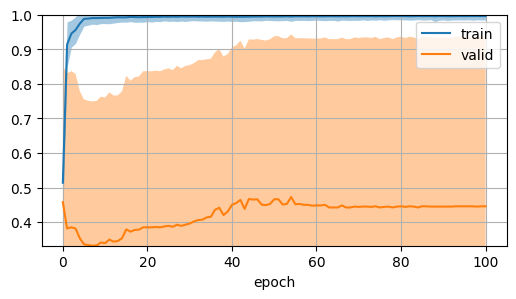

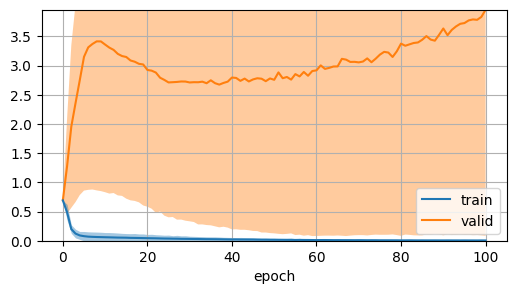

In [23]:
plot_metric(H, max_epoch=epochs, metric="accu")
plot_metric(H, max_epoch=epochs, metric="loss")